<a href="https://colab.research.google.com/github/jairomartinezgiraldo/CNN/blob/main/CNNVIERNES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Importar librerías necesarias
import os
from google.colab import files
from google.colab import drive
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Importar los callbacks

# Carga - Conectar Google Drive y Descargar el Dataset


In [47]:

# Descargar el dataset de Yoga desde Kaggle
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset

# Descomprimir el archivo descargado
import zipfile
with zipfile.ZipFile('yoga-posture-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/yoga_dataset')

print("Dataset descargado y extraído exitosamente.")


Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
100% 446M/447M [00:21<00:00, 23.9MB/s]
100% 447M/447M [00:21<00:00, 21.5MB/s]
Dataset descargado y extraído exitosamente.


In [48]:

# Montamos Google Drive para el almacenamiento del modelo y resultado.
drive.mount('/content/drive')

# Definimos la ruta del dataset y la estructura de carpetas en Google Drive
base_dir = '/content/yoga_dataset'
drive_dir = '/content/drive/MyDrive/yoga_pose_classification'

# Creamos las carpetas en Google Drive para almacenar los resultados y el mejor modelo
os.makedirs(drive_dir, exist_ok=True)
os.makedirs(f"{drive_dir}/results", exist_ok=True)
os.makedirs(f"{drive_dir}/models", exist_ok=True)

# Confirmamos la estructura de carpetas
print("Estructura de carpetas:")
print(f"Dataset en: {base_dir}")
print(f"Resultados en: {drive_dir}/results")
print(f"Modelos en: {drive_dir}/models")#


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estructura de carpetas:
Dataset en: /content/yoga_dataset
Resultados en: /content/drive/MyDrive/yoga_pose_classification/results
Modelos en: /content/drive/MyDrive/yoga_pose_classification/models


# Inspección - Análisis del dataset



*   Verificación de las subcarpetas del dataset, observando las diferentes clases de posturas de yoga.
*   Cada clase tiene un numero distinto de imagenes.
* A partir del dataset identificar y reconocer las distintas poses de yoga.



In [49]:
subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(f"Total de clases: {len(subfolders)}")
print("Clases encontradas:", subfolders)

Total de clases: 47
Clases encontradas: ['Ardha Chandrasana', 'Dhanurasana', 'Pincha Mayurasana', 'Trikonasana', 'Eka Pada Rajakapotasana', 'Virabhadrasana Two', 'Sivasana', 'Utkatasana', 'Garudasana', 'Baddha Konasana', 'Salamba Bhujangasana', 'Halasana', 'Utthita Hasta Padangusthasana', 'Bakasana', 'Virabhadrasana Three', 'Navasana', 'Urdhva Dhanurasana', 'Setu Bandha Sarvangasana', 'Uttanasana', 'Padmasana', 'Adho Mukha Svanasana', 'Utthita Parsvakonasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Urdhva Mukha Svsnssana', 'Camatkarasana', 'Malasana', 'Paschimottanasana', 'Parsvottanasana', 'Ustrasana', 'Balasana', 'Anjaneyasana', 'Vasisthasana', 'Ardha Navasana', 'Adho Mukha Vrksasana', 'Hanumanasana', 'Ardha Matsyendrasana', 'Vrksasana', 'Upavistha Konasana', 'Supta Kapotasana', 'Phalakasana', 'Virabhadrasana One', 'Salamba Sarvangasana', 'Marjaryasana', 'Bitilasana', 'Parsva Virabhadrasana', 'Alanasana']


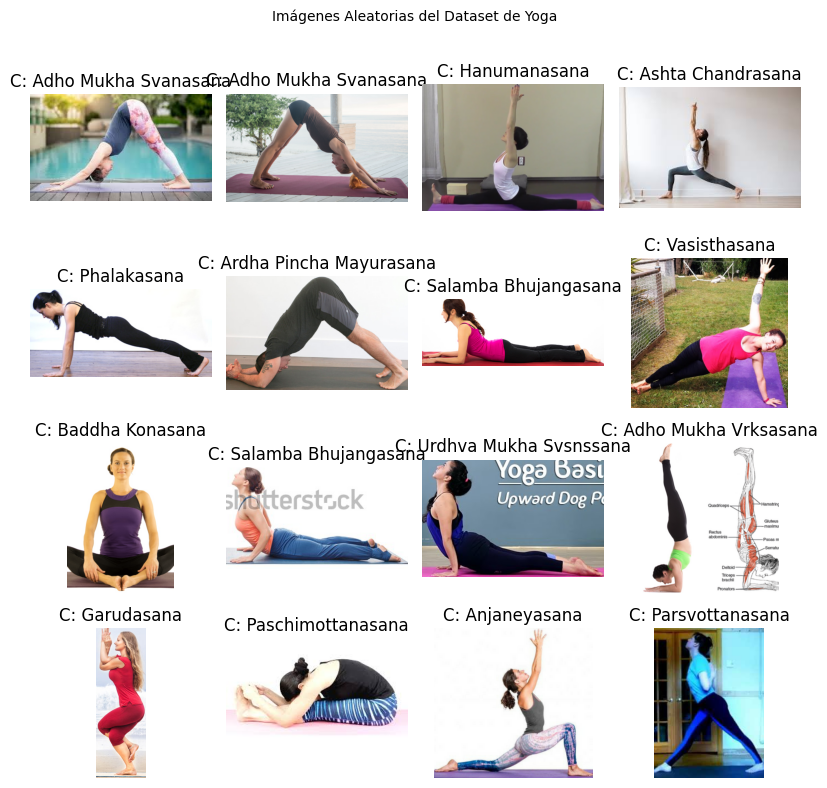

In [50]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Imágenes Aleatorias del Dataset de Yoga', fontsize=10)

for ax in axes.flatten():
    chosen_folder = np.random.choice(subfolders)
    subfolder_path = os.path.join(base_dir, chosen_folder)

    # Verificar que la carpeta contiene imágenes, podemos observar distintos formatos de imagenes.
    images = [img for img in os.listdir(subfolder_path) if img.endswith(('.png', '.jpeg', '.jpg'))]
    if not images:  # Si la carpeta está vacía o no tiene imágenes, salta esta iteración
        ax.set_title('Sin imágenes')
        ax.axis('off')
        continue

    # Seleccionamos imagenes aleatoria para verificar la correcta carga de imagenes.
    img_name = np.random.choice(images)
    img_path = os.path.join(subfolder_path, img_name)

    # Mostramos las imagenes.
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"C: {chosen_folder}")
    else:
        ax.set_title('Imagen no encontrada')
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Paso 3: Configuración de Generadores de Datos con Aumento de Datos
Para entrenar nuestra red de manera eficiente y mejorar su capacidad de generalización, usaremos Data Augmentation o aumento de datos. Esta técnica permite crear variaciones de las imágenes originales aplicando transformaciones como rotaciones, cambios de tamaño y espejado. De esta forma, la red "ve" más datos y puede aprender mejor.

# Acondicionamiento - preprocesamiento de imágenes



* Configuración de ImageDataGenerator para Entrenamiento, Validación y Prueba
* Habilitamos generadores de datos para entrenamiento y validación





In [51]:
# Tamaño de imagen ajustado para MobileNetV2
IMG_SIZE = (224, 224)

# Configuración del aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Dividir el dataset en 70% entrenamiento y 30% (para validación y prueba)
)

# Generador de datos para el conjunto de entrenamiento (70% del total)
# Usamos flow_from_directory mejorar la eficiencia
train_generator = train_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'  # RGB para MobileNetV2
)

# Generador de datos para el conjunto de validación (15% del total)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
val_generator = val_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

# Generador de datos para el conjunto de prueba (15% del total)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)
test_generator = test_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False  # Matener orden de las clases
)

Found 1953 images belonging to 47 classes.
Found 1366 images belonging to 47 classes.
Found 1366 images belonging to 47 classes.


# Definición de callbacks


*   EarlyStopping: Detener el entrenamiento si no hay mejoras.
*   ModelCheckpoint: Guardar el mejor modelo en Google Drive.
*  ReduceLROnPlateau: Ajustar la tasa de aprendizaje automáticamente para una mejor convergencia.



In [52]:
model_path = '/content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras'

# Early Stopping, ventaja evitar sobreajuste.

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# Model Checkpointing guarda el mejor modelo,
# permitiendo recuperarlo para futuras predicciones o continuar el entrenamiento.

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau reduce la tasa de aprendizaje cuando el modelo deja de mejorar,
# ayudando al modelo a converger de manera más fina.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Desarrollo de la arquitectura - Transfer Learning

Usamos MobileNetV2 por su excelente balance entre precisión y velocidad, que ya ha sido entrenada en millones de imágenes (de ImageNet). Esto significa que MovilnetV2 ya ha aprendido muchas características útiles para reconocer objetos.

In [53]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Construir las capas adicionales para la clasificación
x = base_model.output
x = layers.Flatten()(x)  # Utilizar Flatten para conservar toda la información espacial
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(47, activation='softmax')(x)  # 47 clases de poses de yoga

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento inicial (solo las capas añadidas)
history_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Suficientes épocas para observar convergencia en Transfer Learning
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/62 ━━━━━━━━━━━━━━━━━━━━ 28s 552ms/step - accuracy: 0.0403 - loss: 10.2613

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.1139 - loss: 10.1622
Epoch 1: val_accuracy improved from -inf to 0.52416, saving model to /content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 57s 752ms/step - accuracy: 0.1148 - loss: 10.1557 - val_accuracy: 0.5242 - val_loss: 7.1429 - learning_rate: 0.0010
Epoch 2/15
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3657 - loss: 7.1837
Epoch 2: val_accuracy improved from 0.52416 to 0.61054, saving model to /content/drive/MyDrive/yoga_pose_classification/best_yoga_pose_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 674ms/step - accuracy: 0.3663 - loss: 7.1685 - val_accuracy: 0.6105 - val_loss: 5.1557 - learning_rate: 0.0010
Epoch 3/15
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4810 - loss: 5.5743
Epoch 3: val_accuracy did not improve from 0.61054
62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 603ms/step - accuracy: 0.4803 - loss: 5.5743 - val_accuracy: 0.5937 - val_loss: 4.8993 - learn

# Evaluación y Graficación de Métricas- Transfer Learning

Una vez completado el primer entrenamiento, evaluaremos las métricas de precisión y pérdida para ver cómo ha aprendido el modelo hasta ahora.

In [54]:
# Evaluación en Transfer Learning
results_transfer = model.evaluate(test_generator, verbose=0)
print("    Test Loss (Transfer Learning): {:.5f}".format(results_transfer[0]))
print("Test Accuracy (Transfer Learning): {:.2f}%".format(results_transfer[1] * 100))

# Predicción y reporte de clasificación
predictions_transfer = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Transfer Learning:")
print(classification_report(test_generator.classes, predictions_transfer.argmax(axis=1), target_names=test_generator.class_indices.keys()))

    Test Loss (Transfer Learning): 2.36409
Test Accuracy (Transfer Learning): 77.23%
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step
Reporte de Clasificación - Transfer Learning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.65      0.86      0.74        37
         Adho Mukha Vrksasana       0.77      0.72      0.74        32
                    Alanasana       0.30      0.33      0.32         9
                 Anjaneyasana       0.51      0.83      0.63        35
            Ardha Chandrasana       0.91      0.72      0.81        29
         Ardha Matsyendrasana       0.65      0.92      0.76        48
               Ardha Navasana       0.71      0.83      0.77         6
      Ardha Pincha Mayurasana       0.70      0.78      0.74        27
            Ashta Chandrasana       0.50      0.17      0.25         6
              Baddha Konasana       0.45      0.90      0.60        40
                     Bakasana       0.75     

Reporte de Clasificación
* Precisión Global: El conjunto de prueba es del 77.23%, es un buen resultado para multiclases
* Métricas por Clase:
las clase Adho Mukha Svanasana y Vasisthasana, tienen métricas más bajas en términos de precisión y recall, al modelo se le dificulta identicar estas poses.
* Otras clases, como Parsvottanasana y Supta Kapotasana, muestran métricas muy altas (con precisión y recall cerca de 1.0), lo que sugiere que el modelo tiene más facilidad para reconocer estas poses.
* Macro y Weighted Averages: la precisión macro es de 0.81, el modelo tiene un buen desempeño en la mayoría de las clases.


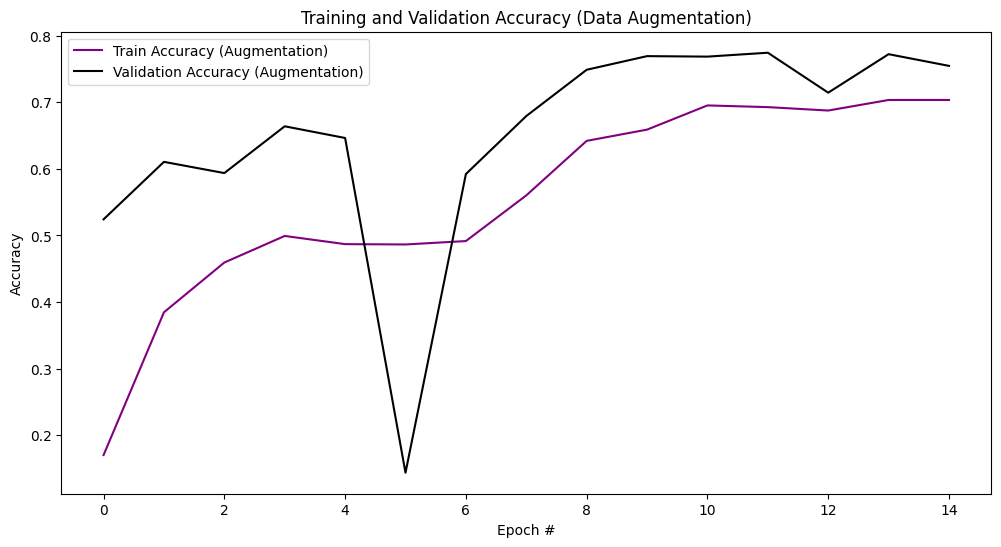

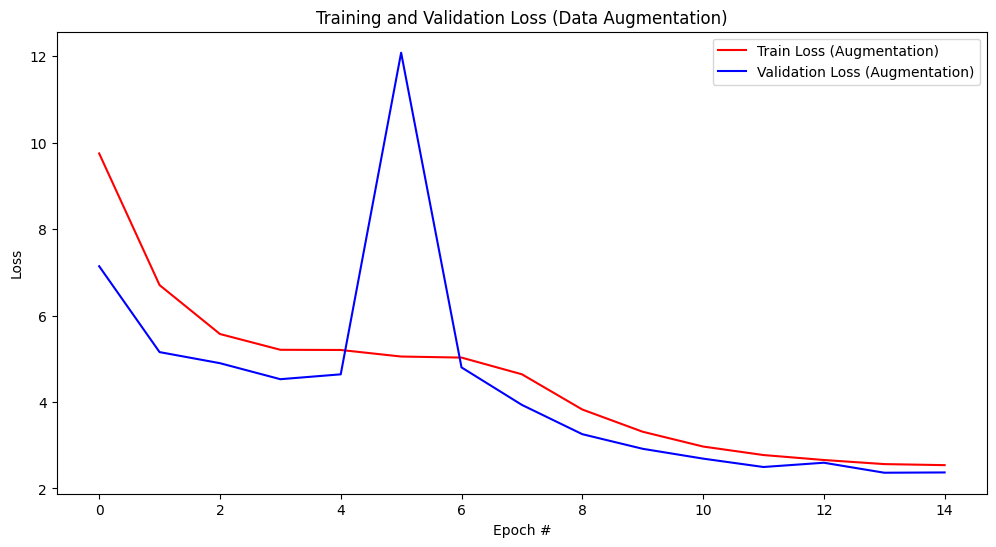

In [55]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["accuracy"], label="Train Accuracy (Augmentation)", color='purple')
plt.plot(history_aug.history["val_accuracy"], label="Validation Accuracy (Augmentation)", color='black')
plt.title("Training and Validation Accuracy (Data Augmentation)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Data Augmentation
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["loss"], label="Train Loss (Augmentation)", color='red')
plt.plot(history_aug.history["val_loss"], label="Validation Loss (Augmentation)", color='blue')
plt.title("Training and Validation Loss (Data Augmentation)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()




# Desarrollo de la arquitectura - Fine-Tuning

Ahora vamos a realizar Fine-Tuning , descongelaremos algunas capas para que el modelo pueda ajustar mejor las características del conjunto de datos. Permitiendo un análisis  más profundo, esto nos ayuda para evitar sobreajuste en algunos casos.

In [57]:
# Descongelar parcialmente el modelo base
fine_tune_at = 120  # Descongelar capas a partir de la capa 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.trainable = True

# Compilar el modelo nuevamente con una tasa de aprendizaje menor
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento con Fine-Tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8577 - loss: 1.3935
Epoch 1: val_accuracy did not improve from 0.83016
62/62 ━━━━━━━━━━━━━━━━━━━━ 68s 772ms/step - accuracy: 0.8576 - loss: 1.3939 - val_accuracy: 0.7240 - val_loss: 2.1620 - learning_rate: 1.0000e-04
Epoch 2/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8843 - loss: 1.2920
Epoch 2: val_accuracy did not improve from 0.83016
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 571ms/step - accuracy: 0.8838 - loss: 1.2930 - val_accuracy: 0.7877 - val_loss: 1.7690 - learning_rate: 1.0000e-04
Epoch 3/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8984 - loss: 1.2050
Epoch 3: val_accuracy did not improve from 0.83016
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 569ms/step - accuracy: 0.8978 - loss: 1.2059 - val_accuracy: 0.7936 - val_loss: 1.7242 - learning_rate: 1.0000e-04
Epoch 4/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8982 - loss: 1.1811
Epoch 4: val_accuracy did not improve from 0.83016
62/62 ━━━━━━━━

In [58]:
# Evaluación en Fine-Tuning
results_fine_tuning = model.evaluate(test_generator, verbose=0)
print("    Test Loss (Fine-Tuning): {:.5f}".format(results_fine_tuning[0]))
print("Test Accuracy (Fine-Tuning): {:.2f}%".format(results_fine_tuning[1] * 100))

# Predicción y reporte de clasificación en Fine-Tuning
predictions_fine = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning:")
print(classification_report(test_generator.classes, predictions_fine.argmax(axis=1), target_names=test_generator.class_indices.keys()))


    Test Loss (Fine-Tuning): 2.16195
Test Accuracy (Fine-Tuning): 72.40%
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step
Reporte de Clasificación - Fine-Tuning:
                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.89      0.86      0.88        37
         Adho Mukha Vrksasana       0.53      0.84      0.65        32
                    Alanasana       1.00      0.22      0.36         9
                 Anjaneyasana       0.43      0.91      0.59        35
            Ardha Chandrasana       0.96      0.93      0.95        29
         Ardha Matsyendrasana       1.00      0.58      0.74        48
               Ardha Navasana       1.00      0.33      0.50         6
      Ardha Pincha Mayurasana       0.94      0.59      0.73        27
            Ashta Chandrasana       1.00      0.17      0.29         6
              Baddha Konasana       0.96      0.57      0.72        40
                     Bakasana       0.41      0.95      0.58   

# Evaluación y Graficación de Métricas- Fine-Tuning

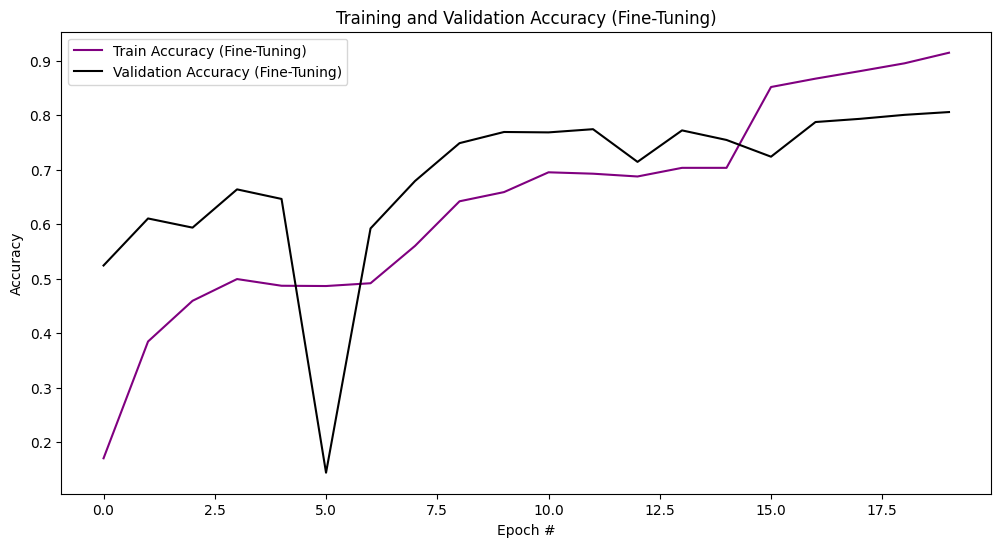

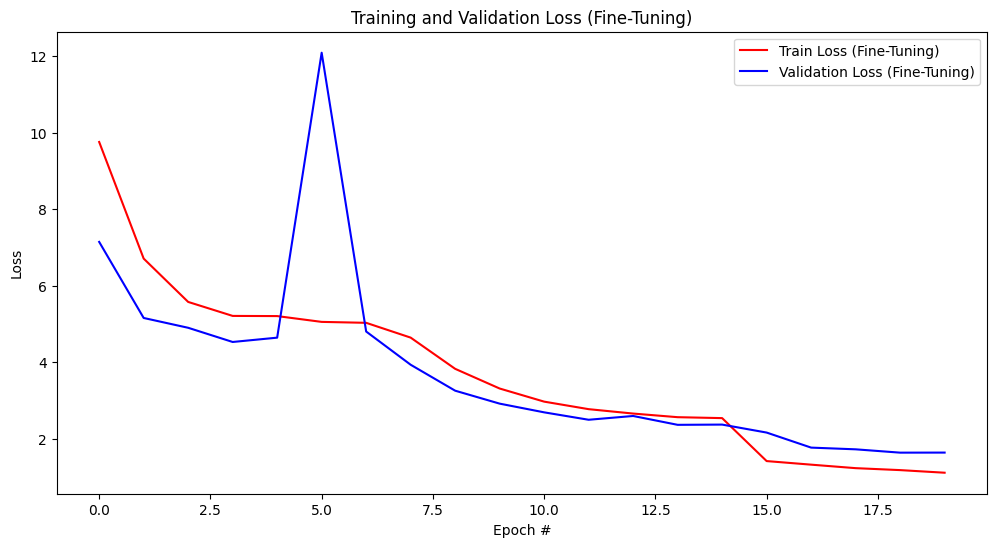

In [59]:
# Graficar Accuracy de entrenamiento y validación de Fine-Tuning


acc = history_aug.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_aug.history['val_accuracy'] + history_fine.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.plot(range(len(acc)), acc, label='Train Accuracy (Fine-Tuning)', color='purple')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy (Fine-Tuning)', color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Fine-Tuning
loss = history_aug.history['loss'] + history_fine.history['loss']
val_loss = history_aug.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 6))
plt.plot(range(len(loss)), loss, label='Train Loss (Fine-Tuning)', color='red')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss (Fine-Tuning)', color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()